In [1]:
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima, ADFTest
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from mutil import *


# Cargar los datasets

Most common crime:  Agresión-Persona


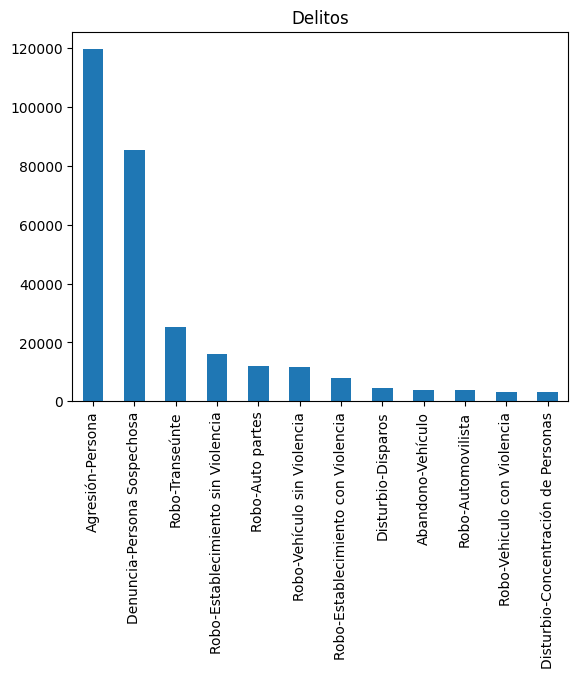

In [2]:
df_delitos, df_camaras = load_data()
df_delitos = preprocess_data(df_delitos, df_camaras)

#find out the most common crime
delitos = df_delitos['incidente_c4'].value_counts().sort_values(ascending=False)
# get the most common crime
delito = delitos.index[0]
most_common_crime = delito
print('Most common crime: ', most_common_crime)
delitos.plot(kind='bar', title='Delitos')
plt.show()

# Filter df_delitos by most common crime
df_delitos = df_delitos[df_delitos['incidente_c4'] == most_common_crime]
df_delitos = df_delitos.groupby('id_camara')

In [3]:
df_delitos.head()

,fecha_creacion,hora_creacion,incidente_c4,colonia,delegacion_inicio,sector_inicio,latitud,longitud,año_creacion,mes_creacion,dia_creacion,dia_semana,semana_creacion,id_camara
0,2022-04-13,20:00,Agresión-Persona,CENTRO (AREA 4),CUAUHTEMOC,ALAMEDA,19.435991,-99.147213,2022,4,13,2,15,1
2,2022-04-06,16:00,Agresión-Persona,CENTRO (AREA 5),CUAUHTEMOC,ALAMEDA,19.434847,-99.146744,2022,4,6,2,14,1
4,2022-04-12,08:00,Agresión-Persona,CENTRO (AREA 5),CUAUHTEMOC,ALAMEDA,19.435283,-99.147152,2022,4,12,1,15,1
5,2022-04-12,18:00,Agresión-Persona,CENTRO (AREA 5),CUAUHTEMOC,ALAMEDA,19.435157,-99.146876,2022,4,12,1,15,1
7,2022-04-15,18:00,Agresión-Persona,CENTRO (AREA 4),CUAUHTEMOC,ALAMEDA,19.435945,-99.147299,2022,4,15,4,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296175,2022-04-19,02:00,Agresión-Persona,AMPLIACION PENITENCIARIA,VENUSTIANO CARRANZA,CONGRESO,19.435560,-99.119960,2022,4,19,1,16,MC17609
296176,2022-04-04,09:00,Agresión-Persona,AMPLIACION PENITENCIARIA,VENUSTIANO CARRANZA,CONGRESO,19.435966,-99.119655,2022,4,4,0,14,MC17609
296179,2022-04-28,13:00,Agresión-Persona,AMPLIACION PENITENCIARIA,VENUSTIANO CARRANZA,CONGRESO,19.435140,-99.120235,2022,4,28,3,17,MC17609
296183,2022-08-24,08:00,Agresión-Persona,AMPLIACION PENITENCIARIA,VENUSTIANO CARRANZA,CONGRESO,19.435966,-99.119655,2022,8,24,2,34,MC17609


In [4]:
"""# Find group with most data
max_len = 0
max_id = 0
for id_camara, df in df_delitos:
	if len(df) > max_len:
		max_len = len(df)
		max_id = id_camara

print(max_id, max_len) 
"""

'# Find group with most data\nmax_len = 0\nmax_id = 0\nfor id_camara, df in df_delitos:\n\tif len(df) > max_len:\n\t\tmax_len = len(df)\n\t\tmax_id = id_camara\n\nprint(max_id, max_len) \n'

In [5]:
# # get group by '1'
# df_delitos = df_delitos.get_group('MC3857')
# print(len(df_delitos))
# df_delitos.head()


In [6]:
"""#split the data into train (whole dates in 2022) and test (whole dates in 2023)
train = df_delitos[df_delitos.fecha_creacion.dt.year == 2022]
test = df_delitos[df_delitos.fecha_creacion.dt.year == 2023]

# Count the number of crimes per day but saving the date and the id_camara
df_delitos_train_count = train.groupby(['id_camara', 'fecha_creacion']).size().reset_index(name='count')
df_delitos_test_count = test.groupby(['id_camara', 'fecha_creacion']).size().reset_index(name='count')

# recorre df_delitos_train_count por los 365 dias del año 2022, donde no hay datos, los rellena con 0 en count
df_delitos_train_count = df_delitos_train_count.set_index('fecha_creacion').reindex(pd.date_range(start='2022-01-01', end='2022-12-31')).reset_index().rename(columns={'index': 'fecha_creacion'})
df_delitos_train_count['count'] = df_delitos_train_count['count'].fillna(0)

# recorre df_delitos_test_count por los 365 dias del año 2023, donde no hay datos, los rellena con 0 en count
df_delitos_test_count = df_delitos_test_count.set_index('fecha_creacion').reindex(pd.date_range(start='2023-01-01', end='2023-01-31')).reset_index().rename(columns={'index': 'fecha_creacion'})
df_delitos_test_count['count'] = df_delitos_test_count['count'].fillna(0)

print(f'Number of observations in train: {len(df_delitos_train_count)} ({(len(df_delitos_train_count)*100/len(df_delitos)):.2f})%')
print(f'Number of observations in test: {len(df_delitos_test_count)} ({(len(df_delitos_test_count)*100/len(df_delitos)):.2f})%')
"""

"#split the data into train (whole dates in 2022) and test (whole dates in 2023)\ntrain = df_delitos[df_delitos.fecha_creacion.dt.year == 2022]\ntest = df_delitos[df_delitos.fecha_creacion.dt.year == 2023]\n\n# Count the number of crimes per day but saving the date and the id_camara\ndf_delitos_train_count = train.groupby(['id_camara', 'fecha_creacion']).size().reset_index(name='count')\ndf_delitos_test_count = test.groupby(['id_camara', 'fecha_creacion']).size().reset_index(name='count')\n\n# recorre df_delitos_train_count por los 365 dias del año 2022, donde no hay datos, los rellena con 0 en count\ndf_delitos_train_count = df_delitos_train_count.set_index('fecha_creacion').reindex(pd.date_range(start='2022-01-01', end='2022-12-31')).reset_index().rename(columns={'index': 'fecha_creacion'})\ndf_delitos_train_count['count'] = df_delitos_train_count['count'].fillna(0)\n\n# recorre df_delitos_test_count por los 365 dias del año 2023, donde no hay datos, los rellena con 0 en count\ndf_de

In [7]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df_delitos_train_count['fecha_creacion'], df_delitos_train_count['count'], label='Train')
plt.show()

NameError: name 'df_delitos_train_count' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
import multiprocessing

def worker(num):
    """Función trabajadora que imprime el número recibido"""
    print(f'Worker {num} is running')

if __name__ == '__main__':
    jobs = []
    for i in range(5):
        p = multiprocessing.Process(target=worker, args=(i,))
        jobs.append(p)
        p.start()

In [14]:
import multiprocessing

def worker(num_proc):
	"""Función trabajadora que imprime el número recibido"""
	
	return print("Hola", num_proc)
	# print(f'Worker {num_proc}/{tot_procs} is running')
	# print(f'Current values: min=[{index[0]}]{values[0]}, max=[{index[1]}]{values[1]}')
	# print(proc_df_delitos)

values = [math.inf, -math.inf]
index = [None, None]
jobs = []
total = 5

#print(list(df_delitos.groups.keys()))

proc_groups = np.array_split(list(df_delitos.groups.keys()), total) # NOTE: revisar si regresa grupos completos (reportes por camara)
for i in range(total):
	print('1')
	p = multiprocessing.Process(target=worker, args=(i,))
	print('2')
	p.start()
	print('3')

1
2
3
1
2
3
1
2
3
1
2
3
1
2
3


Processing 1/23953 ID:1...


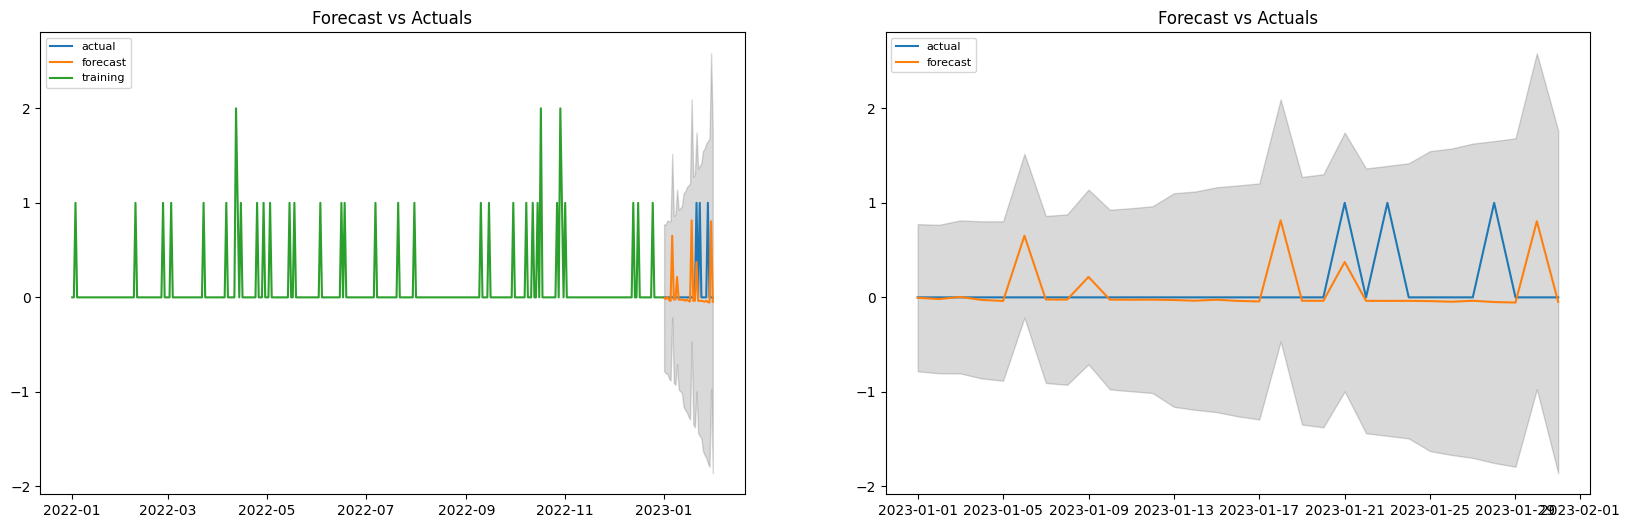

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        28
         1.0       0.00      0.00      0.00         3

    accuracy                           0.90        31
   macro avg       0.45      0.50      0.47        31
weighted avg       0.82      0.90      0.86        31

Processing 2/23953 ID:10...


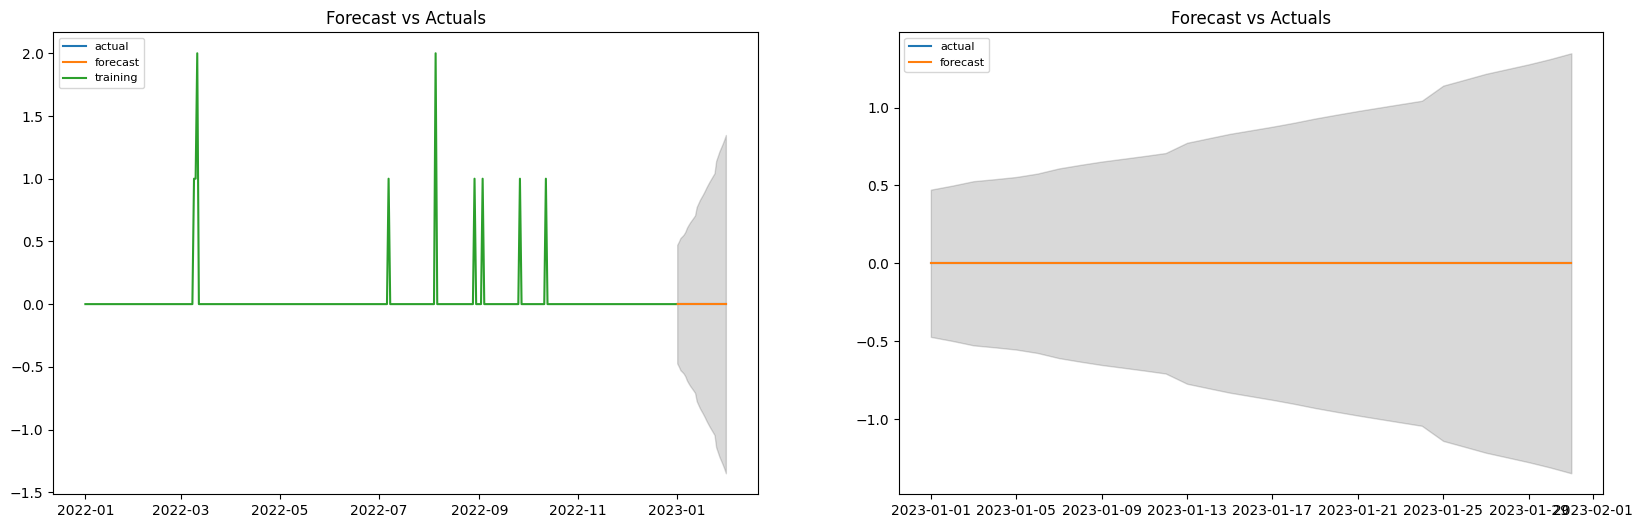

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Processing 3/23953 ID:100...


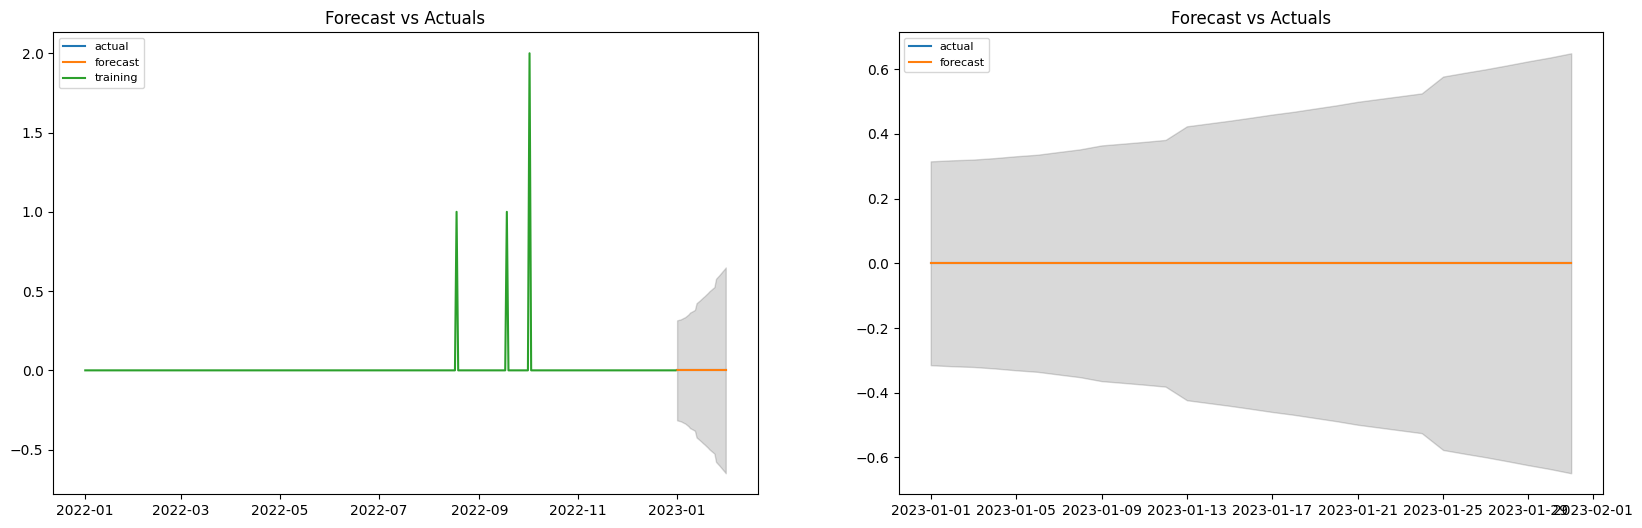

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Processing 4/23953 ID:1000...


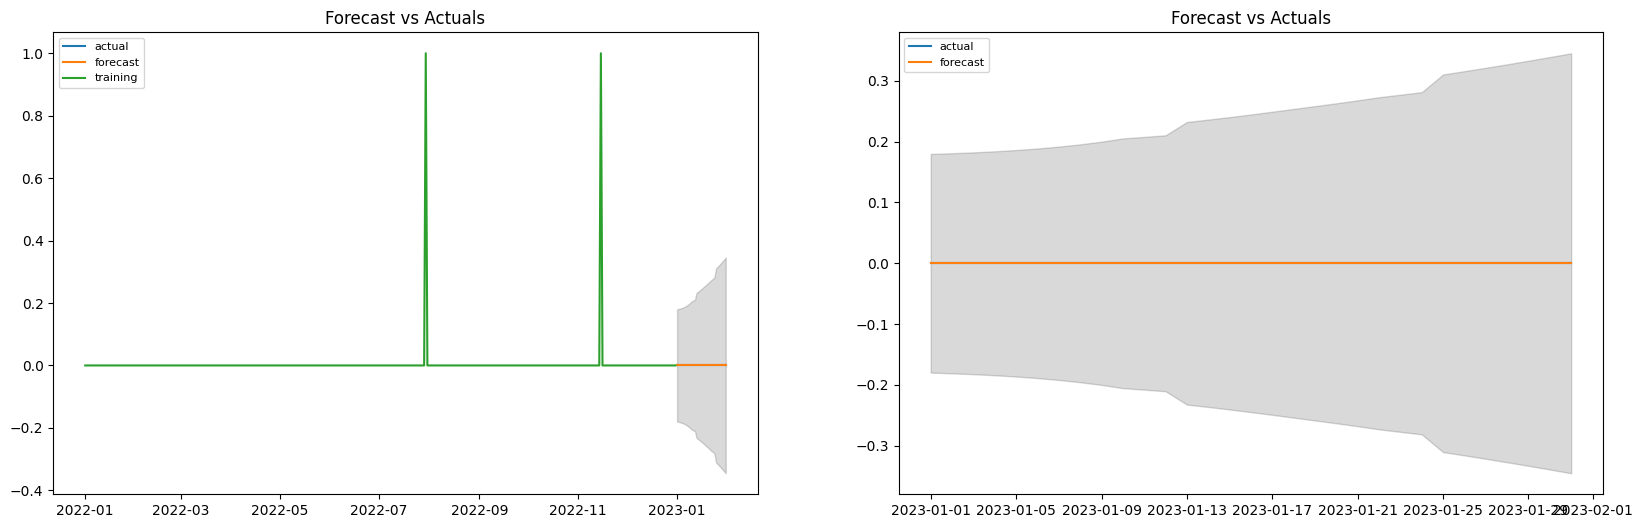

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Processing 5/23953 ID:10000...


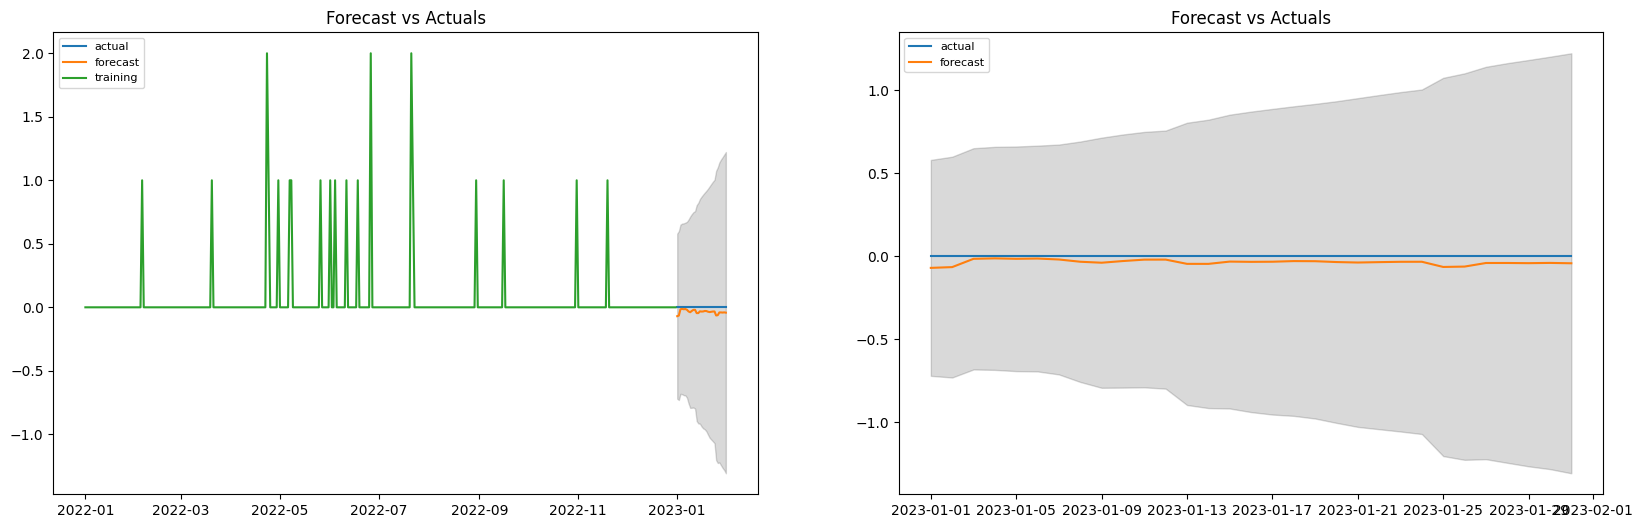

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Processing 6/23953 ID:10001...


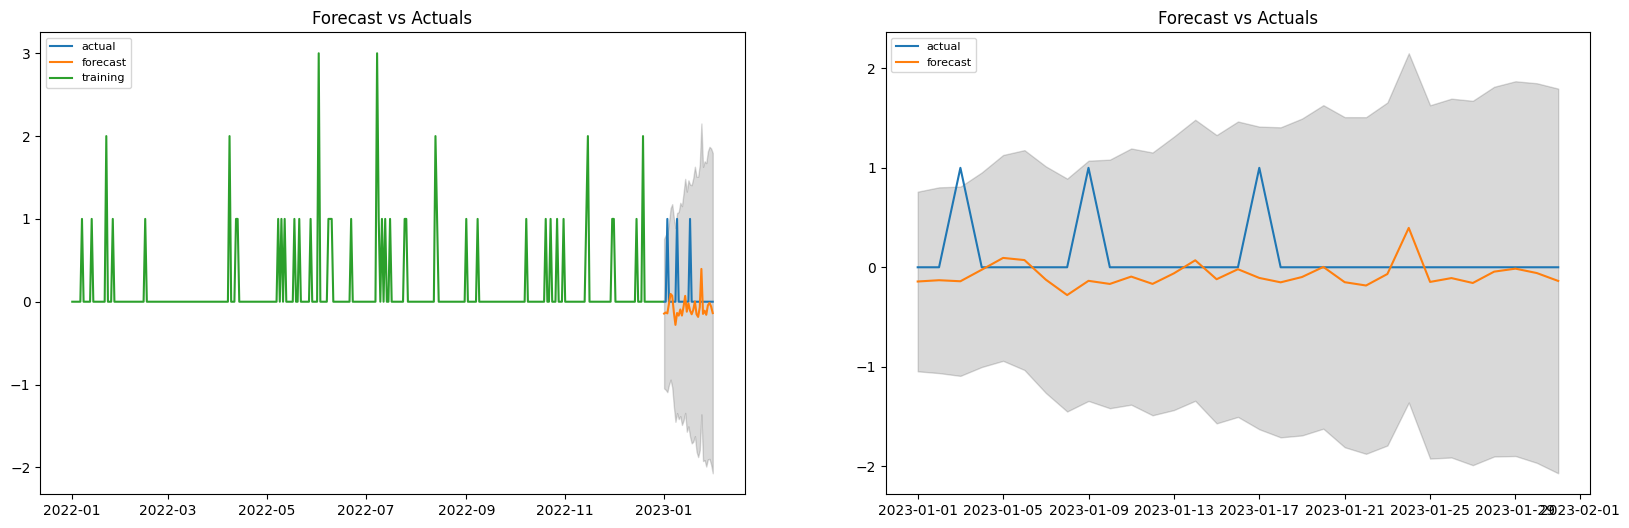

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        28
         1.0       0.00      0.00      0.00         3

    accuracy                           0.90        31
   macro avg       0.45      0.50      0.47        31
weighted avg       0.82      0.90      0.86        31

Processing 7/23953 ID:10002...


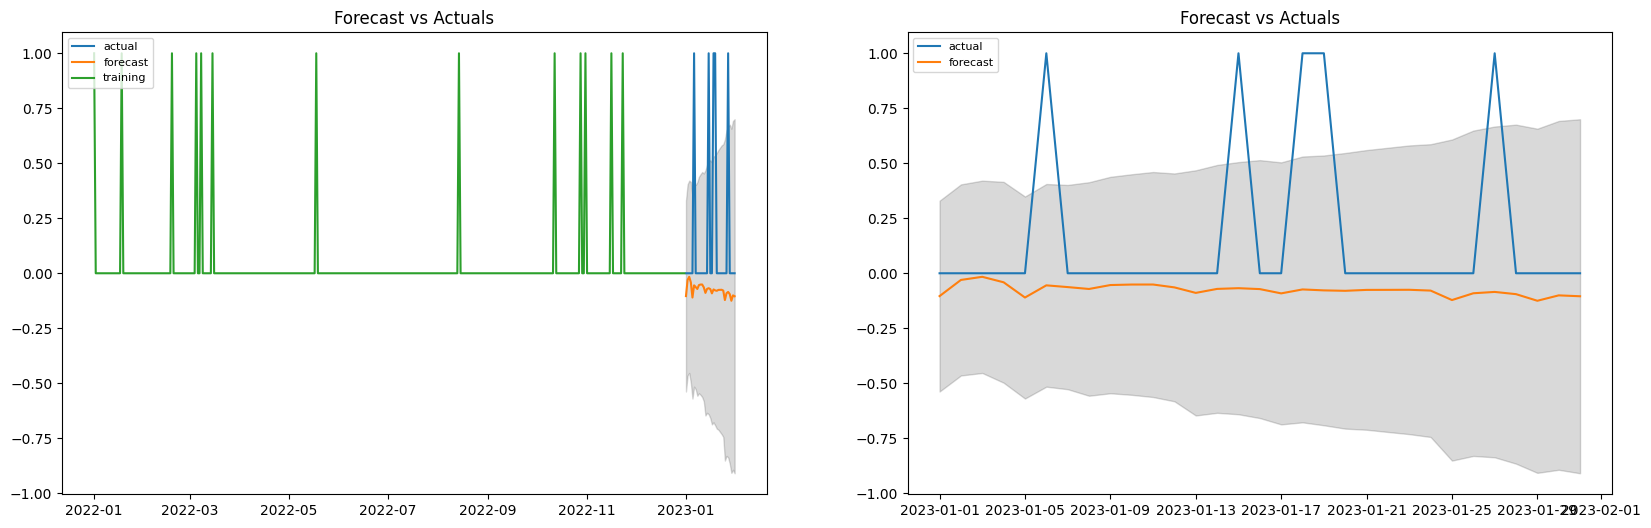

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91        26
         1.0       0.00      0.00      0.00         5

    accuracy                           0.84        31
   macro avg       0.42      0.50      0.46        31
weighted avg       0.70      0.84      0.77        31

Processing 8/23953 ID:10003...


KeyboardInterrupt: 

In [140]:
# Análisis estádistico utilizando auto ARIMA

# save the minumum error and best error 
min_value = math.inf
max_value = -math.inf

i=0
for id_camara, df in df_delitos:
    i+=1
    print(f'Processing {i}/{len(df_delitos.groups)} ID:{id_camara}...')

    # Count the number of crimes per day but saving the date and the id_camara and set the fecha_creacion as index
    df_delitos_count = df.groupby(['id_camara', 'fecha_creacion']).size().reset_index(name='count')
    # Fill the missing dates with 0
    df_delitos_count = df_delitos_count.set_index('fecha_creacion').reindex(pd.date_range(start='2022-01-01', end='2023-01-31')).reset_index().rename(columns={'index': 'fecha_creacion'})
    df_delitos_count['count'] = df_delitos_count['count'].fillna(0)
    df_delitos_count['id_camara'] = df_delitos_count['id_camara'].fillna(id_camara)

    # Split the data into train (whole dates in 2022) and test (whole dates in 2023)
    train = df_delitos_count[df_delitos_count.fecha_creacion.dt.year == 2022]
    test = df_delitos_count[df_delitos_count.fecha_creacion.dt.year == 2023]

    y_train = train['count']
    y_test = test['count']

    x_train = train['fecha_creacion']
    x_test = test['fecha_creacion']

    # Fit auto_arima function with dep_var 'count' jusing test dicker fuller
    stepwise_fit = auto_arima(y_train, stationary=False, 
                            test='adf', start_p=1, d=1, start_q=0,
                            max_p=8, max_d=2, max_q=7,
                            m=12,
                            seasonal=True,
                            seasonal_test='ch', start_P=2, D=1, start_Q=0,
                            trace=False, stepwise=True,
                            suppress_warnings=True, error_action='ignore',
                            random_state=20, n_fits=50)
    
    # Print the summary
    # print(stepwise_fit.summary())

    # Forecast for the next 365 days
    n_periods = len(y_test)
    fc, confint = stepwise_fit.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = np.arange(len(y_train), len(y_train)+n_periods)

    # make series for plotting purpose
    fc_series = pd.Series(fc, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot 2 images. 1) with training, test and forecast with confidence interval. 2) test vs forecast with confidence interval
    plt.subplots(1, 2, figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x_test, y_test, label='actual')
    plt.plot(x_test, fc_series, label='forecast')
    plt.fill_between(x_test, lower_series, upper_series, color='k', alpha=.15)
    plt.plot(x_train, y_train, label='training')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.subplot(1, 2, 2)
    plt.plot(x_test, y_test, label='actual')
    plt.plot(x_test, fc_series, label='forecast')
    plt.fill_between(x_test, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

    
    # print classification report
    print(classification_report(y_test, fc.copy().astype(int), zero_division=0))

    if mean_squared_error(y_test, fc) < min_value:
        min_value = mean_squared_error(y_test, fc)
        min_id = id_camara
    if mean_squared_error(y_test, fc) > max_value:
        max_value = mean_squared_error(y_test, fc)
        max_id = id_camara
    
# Print the min and max mean absolute error
print(f'Min Mean Absolute Error: {min_value} for {min_id}')
print(f'Max Mean Absolute Error: {max_value} for {max_id}')

In [ ]:
# Análisis estádistico utilizando ARIMA

# To install statsmodels use conda install -c conda-forge statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# To install pmdarima use conda install -c conda-forge pmdarima
from pmdarima import auto_arima 

df_by_delitos = df.groupby('incidente_c4')

for delito, delito_df in df_by_delitos:
	print('delito', delito)

	delito_df_pt = delito_df.groupby('fecha_creacion').count()#['incidente_c4'].to_frame()
	delito_df_pt.rename(columns={'incidente_c4':'obs'}, inplace=True)
	delito_arima_df = delito_df_pt[['obs']]
	print('delito_df_pt', delito_arima_df)
	#print('columns', delito_df_pt.columns)

	#find if one day is missing and print it
	for i in range(len(delito_arima_df)-1):
		if delito_arima_df.index[i+1] - delito_arima_df.index[i] != pd.Timedelta(days=1):
			print('Missing day', delito_arima_df.index[i+1])
			# add missing day
			
			delito_arima_df.loc[delito_arima_df.index[i+1]] = 0
	
	# Create time series and plot
	RT = delito_arima_df.iloc[-678:].astype(float).squeeze().to_numpy()
	RT = pd.Series(RT, index=pd.date_range(start='2022-01-01', end='2022-12-31', freq='D'))
	plt.plot(RT)

In [ ]:
# To install statsmodels use conda install -c conda-forge statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# To install pmdarima use conda install -c conda-forge pmdarima
from pmdarima import auto_arima 

# Read RDS file
echoT = pd.read_pickle("C:/Users/lpenac/Documents/SUPERBASES/echo_TOTAL.Rds")

# Filter and group data
RoboTranseunte = (
    echoT.loc[echoT['incidente_c4'] == 'Robo-Transeúnte']
        .groupby(['fecha_cierre', 'incidente_c4'])
        .count()
        .reset_index()
        .drop('incidente_c4', axis=1)
)

# Create date range and join with grouped data
date_range = pd.DataFrame({'fecha_cierre': pd.date_range(start='2021-01-01', end='2023-01-30', freq='D')})
Rob = pd.merge(date_range, RoboTranseunte, on='fecha_cierre', how='left')
Rob.fillna(0, inplace=True)
Rob.rename(columns={'n': 'obs'}, inplace=True)
Rob = Rob.drop('fecha_cierre', axis=1)

# Create time series and plot
RT = Rob.iloc[-678:].astype(float).squeeze().to_numpy()
RT = pd.Series(RT, index=pd.date_range(start='2021-03-01', end='2023-01-30', freq='D'))
plt.plot(RT)

# ADF test
result = adfuller(RT)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Plot ACF and PACF
plot_acf(RT, lags=365)
plot_pacf(RT, lags=365)

# Model 1
model1 = ARIMA(RT, order=(1, 0, 1))
model1 = model1.fit()
print(model1.summary())
residuals = model1.resid

# Model 2
model2 = ARIMA(RT, order=(7, 0, 7))
model2 = model2.fit()
print(model2.summary())
residuals = model2.resid

# Forecast with Model 2
forecast = model2.forecast(steps=5)
print(forecast)

# Auto ARIMA
auto = auto_arima(RT, seasonal=False, suppress_warnings=True)
print(auto.summary())

# Model 3
model3 = ARIMA(RT, order=auto.order)
model3 = model3.fit()
print(model3.summary())
residuals = model3
